In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
account_activity = pd.read_csv('account_activity.csv')
customer_data = pd.read_csv('customer_data.csv')
fraud_indicators = pd.read_csv('fraud_indicators.csv')
suspicious_activity = pd.read_csv('suspicious_activity.csv')
merchant_data = pd.read_csv('merchant_data.csv')
transaction_category_labels = pd.read_csv('transaction_category_labels.csv')
amount_data = pd.read_csv('amount_data.csv')
anomaly_scores = pd.read_csv('anomaly_scores.csv')
transaction_metadata = pd.read_csv('transaction_metadata.csv')
transaction_records = pd.read_csv('transaction_records.csv')

In [4]:
account_activity.head()

,CustomerID,AccountBalance,LastLogin
0,1001,9507.272060,2022-01-01
1,1002,7408.704536,2022-01-02
2,1003,1715.321989,2022-01-03
3,1004,3101.509134,2022-01-04
4,1005,5405.766914,2022-01-05


In [5]:
customer_data.head()

,CustomerID,Name,Age,Address
0,1001,Customer 1001,54,Address 1001
1,1002,Customer 1002,35,Address 1002
2,1003,Customer 1003,40,Address 1003
3,1004,Customer 1004,30,Address 1004
4,1005,Customer 1005,46,Address 1005


In [6]:
fraud_indicators.head()

,TransactionID,FraudIndicator
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [7]:
suspicious_activity.head()

,CustomerID,SuspiciousFlag
0,1001,0
1,1002,0
2,1003,0
3,1004,0
4,1005,0


In [8]:
merchant_data.head()

,MerchantID,MerchantName,Location
0,2001,Merchant 2001,Location 2001
1,2002,Merchant 2002,Location 2002
2,2003,Merchant 2003,Location 2003
3,2004,Merchant 2004,Location 2004
4,2005,Merchant 2005,Location 2005


In [9]:
transaction_category_labels.head()

,TransactionID,Category
0,1,Other
1,2,Online
2,3,Travel
3,4,Travel
4,5,Other


In [10]:
amount_data.head()

,TransactionID,TransactionAmount
0,1.0,79.413607
1,2.0,12.053087
2,3.0,33.310357
3,4.0,46.121117
4,5.0,54.051618


In [11]:
anomaly_scores.head()

,TransactionID,AnomalyScore
0,1,0.686699
1,2,0.081749
2,3,0.023857
3,4,0.876994
4,5,0.034059


In [12]:
transaction_metadata.head()

,TransactionID,Timestamp,MerchantID
0,1,01-01-2022 00:00,2701
1,2,01-01-2022 01:00,2070
2,3,01-01-2022 02:00,2238
3,4,01-01-2022 03:00,2879
4,5,01-01-2022 04:00,2966


In [13]:
transaction_records.head()

,TransactionID,Amount,CustomerID
0,1,55.530334,1952
1,2,12.881180,1027
2,3,50.176322,1955
3,4,41.634001,1796
4,5,78.122853,1946


In [14]:
transaction_data = pd.merge(transaction_records, transaction_metadata, on='TransactionID')
transaction_data = pd.merge(transaction_data, amount_data, on='TransactionID')
transaction_data = pd.merge(transaction_data, merchant_data, on='MerchantID')
transaction_data = pd.merge(transaction_data, transaction_category_labels, on='TransactionID')
transaction_data = pd.merge(transaction_data, fraud_indicators, on='TransactionID', how='left')
transaction_data = pd.merge(transaction_data, suspicious_activity, on='CustomerID', how='left')
transaction_data = pd.merge(transaction_data, customer_data, on='CustomerID')

In [15]:
transaction_data.TransactionID


0        1
1      895
2      914
3      294
4        2
      ... 
994    973
995    980
996    984
997    989
998    996
Name: TransactionID, Length: 999, dtype: int64

In [16]:
#transaction_data1 = transaction_data.sort_values(by='TransactionID')


In [61]:
transaction_data.head()


,TransactionID,Amount,CustomerID,MerchantID,TransactionAmount,Category,FraudIndicator,SuspiciousFlag,Age,Merchant_Merchant 2001,...,Location_Location 2997,Location_Location 2998,Location_Location 3000,RMSE,PredictedFraud,MerchantTrustScore,CustomerTrustScore,TransactionTrustScore,AverageTransactionAmount,TransactionFrequency
0,1,55.530334,1952,2701,79.413607,2,0,0,50,False,...,False,False,False,NaN,0,1.0,1.0,1.0,84.917817,2
1,895,53.683898,1952,2149,90.422026,0,0,0,50,False,...,False,False,False,NaN,0,1.0,1.0,1.0,84.917817,2
2,914,96.523142,1009,2701,94.931704,2,0,0,32,False,...,False,False,False,NaN,0,1.0,1.0,1.0,55.927152,2
3,294,35.151451,1009,2253,16.922601,2,0,0,32,False,...,False,False,False,NaN,0,1.0,1.0,1.0,55.927152,2
4,2,12.881180,1027,2070,12.053087,1,0,0,46,False,...,False,False,False,NaN,0,1.0,1.0,1.0,12.053087,1


In [18]:
transaction_data.shape

(999, 14)

In [19]:
###Data Preprocessing

In [20]:

transaction_data = transaction_data.drop(['Timestamp', 'Name', 'Address'], axis=1)


In [21]:
transaction_data['SuspiciousFlag'].fillna(0, inplace=True)
transaction_data['FraudIndicator'].fillna(0, inplace=True)


In [22]:
transaction_data['Category'] = pd.Categorical(transaction_data['Category'])
transaction_data['Category'] = transaction_data['Category'].cat.codes


In [23]:
if 'MerchantName' in transaction_data.columns:
    # Encode 'MerchantName' using one-hot encoding
    transaction_data = pd.get_dummies(transaction_data, columns=['MerchantName'], prefix='Merchant')

# Check if 'Location' is present before one-hot encoding
if 'Location' in transaction_data.columns:
    transaction_data = pd.get_dummies(transaction_data, columns=['Location'])#

In [24]:
X = transaction_data.drop(['TransactionID', 'FraudIndicator', 'SuspiciousFlag'], axis=1)
y = transaction_data['FraudIndicator']


In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [27]:
transaction_data.head()

,TransactionID,Amount,CustomerID,MerchantID,TransactionAmount,Category,FraudIndicator,SuspiciousFlag,Age,Merchant_Merchant 2001,...,Location_Location 2984,Location_Location 2989,Location_Location 2991,Location_Location 2992,Location_Location 2993,Location_Location 2994,Location_Location 2995,Location_Location 2997,Location_Location 2998,Location_Location 3000
0,1,55.530334,1952,2701,79.413607,2,0,0,50,False,...,False,False,False,False,False,False,False,False,False,False
1,895,53.683898,1952,2149,90.422026,0,0,0,50,False,...,False,False,False,False,False,False,False,False,False,False
2,914,96.523142,1009,2701,94.931704,2,0,0,32,False,...,False,False,False,False,False,False,False,False,False,False
3,294,35.151451,1009,2253,16.922601,2,0,0,32,False,...,False,False,False,False,False,False,False,False,False,False
4,2,12.881180,1027,2070,12.053087,1,0,0,46,False,...,False,False,False,False,False,False,False,False,False,False


me![image.png](attachment:a60a3eaa-07d9-49be-a95d-8fc560154576.png))
 

In [28]:
#from IPython.display import Image
#Image("PP.JPG")

In [29]:
#from IPython.display import Image
#Image("op.JPG")

In [30]:

# Update input_dim based on the correct number of features
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(32, activation='relu')(input_layer)
encoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')



In [31]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping])


Epoch 1/20
25/25 [==============================] - 3s 38ms/step - loss: 1.2120 - val_loss: 1.2046
Epoch 2/20
25/25 [==============================] - 0s 9ms/step - loss: 1.0569 - val_loss: 1.0890
Epoch 3/20
25/25 [==============================] - 0s 9ms/step - loss: 0.9938 - val_loss: 1.0675
Epoch 4/20
25/25 [==============================] - 0s 10ms/step - loss: 0.9919 - val_loss: 1.0646
Epoch 5/20
25/25 [==============================] - 0s 14ms/step - loss: 0.9916 - val_loss: 1.0640
Epoch 6/20
25/25 [==============================] - 0s 11ms/step - loss: 0.9915 - val_loss: 1.0637
Epoch 7/20
25/25 [==============================] - 0s 9ms/step - loss: 0.9913 - val_loss: 1.0637
Epoch 8/20
25/25 [==============================] - 0s 10ms/step - loss: 0.9911 - val_loss: 1.0640
Epoch 9/20
25/25 [==============================] - 0s 16ms/step - loss: 0.9909 - val_loss: 1.0644


In [32]:

decoded_data = autoencoder.predict(X_test)
rmse = np.sqrt(np.mean(np.square(X_test - decoded_data), axis=1))


transaction_data['RMSE'] = np.nan
transaction_data.loc[y_test.index, 'RMSE'] = rmse


7/7 [==============================] - 0s 4ms/step


In [33]:

threshold = transaction_data['RMSE'].quantile(0.965)


transaction_data['PredictedFraud'] = 0
transaction_data.loc[transaction_data['RMSE'] > threshold, 'PredictedFraud'] = 1


In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [35]:
merchant_trust_scores = transaction_data.groupby('MerchantID')['RMSE'].mean().reset_index()
merchant_trust_scores.columns = ['MerchantID', 'MerchantTrustScore']

customer_trust_scores = transaction_data.groupby('CustomerID')['RMSE'].mean().reset_index()
customer_trust_scores.columns = ['CustomerID', 'CustomerTrustScore']

transaction_trust_scores = transaction_data.groupby('TransactionID')['RMSE'].mean().reset_index()
transaction_trust_scores.columns = ['TransactionID', 'TransactionTrustScore']

In [36]:
transaction_data = pd.merge(transaction_data, merchant_trust_scores, on='MerchantID', how='left')
transaction_data = pd.merge(transaction_data, customer_trust_scores, on='CustomerID', how='left')
transaction_data = pd.merge(transaction_data, transaction_trust_scores, on='TransactionID', how='left')

In [37]:
trust_threshold = 0.5  # Adjust the threshold based on your preference

# Flag transactions as fraudulent based on the threshold and trust scores
transaction_data['PredictedFraud'] = 0
transaction_data.loc[(transaction_data['RMSE'] > threshold) & (transaction_data['MerchantTrustScore'] < trust_threshold) & 
                      (transaction_data['CustomerTrustScore'] < trust_threshold) & 
                      (transaction_data['TransactionTrustScore'] < trust_threshold), 'PredictedFraud'] = 1

In [38]:
average_transaction_amount = transaction_data.groupby('CustomerID')['TransactionAmount'].mean().reset_index()
average_transaction_amount.columns = ['CustomerID', 'AverageTransactionAmount']
# Calculate the frequency of transactions for each customer
transaction_frequency = transaction_data.groupby('CustomerID').size().reset_index(name='TransactionFrequency')

# Merge additional features back into the main dataframe
transaction_data = pd.merge(transaction_data, average_transaction_amount, on='CustomerID', how='left')
transaction_data = pd.merge(transaction_data, transaction_frequency, on='CustomerID', how='left')

# Fill missing values in the new features
transaction_data['AverageTransactionAmount'].fillna(0, inplace=True)
transaction_data['TransactionFrequency'].fillna(0, inplace=True)


In [39]:
X = transaction_data.drop(['TransactionID', 'FraudIndicator', 'SuspiciousFlag'], axis=1)

# Standardize data including the new features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split with the updated feature set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [43]:
autoencoder.compile(optimizer='adam', loss='mse')

In [55]:
suspicious_threshold = 0.8  # Adjust the threshold based on your preference

# Flag transactions as suspicious based on the threshold error
transaction_data['SuspiciousFlag'] = 0
transaction_data.loc[transaction_data['RMSE'] > suspicious_threshold, 'SuspiciousFlag'] = 1

# Update trust scores based on the suspicious flag and fraud flag
def update_trust_score(trust_score, suspicious_flag, fraud_flag):
    if fraud_flag == 1:
        trust_score = max(0, trust_score - 0.2)  # Decrease trust score more for flagged fraudulent transactions
    else:
        if suspicious_flag == 1:
            trust_score = max(0, trust_score - 0.1)  # Decrease trust score for suspicious transactions
        else:
            trust_score = min(1, trust_score + 0.1)  # Increase trust score for non-suspicious transactions
    return trust_score


In [56]:
# Apply the updated function to update trust scores in the dataframe
transaction_data['MerchantTrustScore'] = transaction_data.apply(lambda row: update_trust_score(row['MerchantTrustScore'], row['SuspiciousFlag'], row['PredictedFraud']), axis=1)
transaction_data['CustomerTrustScore'] = transaction_data.apply(lambda row: update_trust_score(row['CustomerTrustScore'], row['SuspiciousFlag'], row['PredictedFraud']), axis=1)
transaction_data['TransactionTrustScore'] = transaction_data.apply(lambda row: update_trust_score(row['TransactionTrustScore'], row['SuspiciousFlag'], row['PredictedFraud']), axis=1)

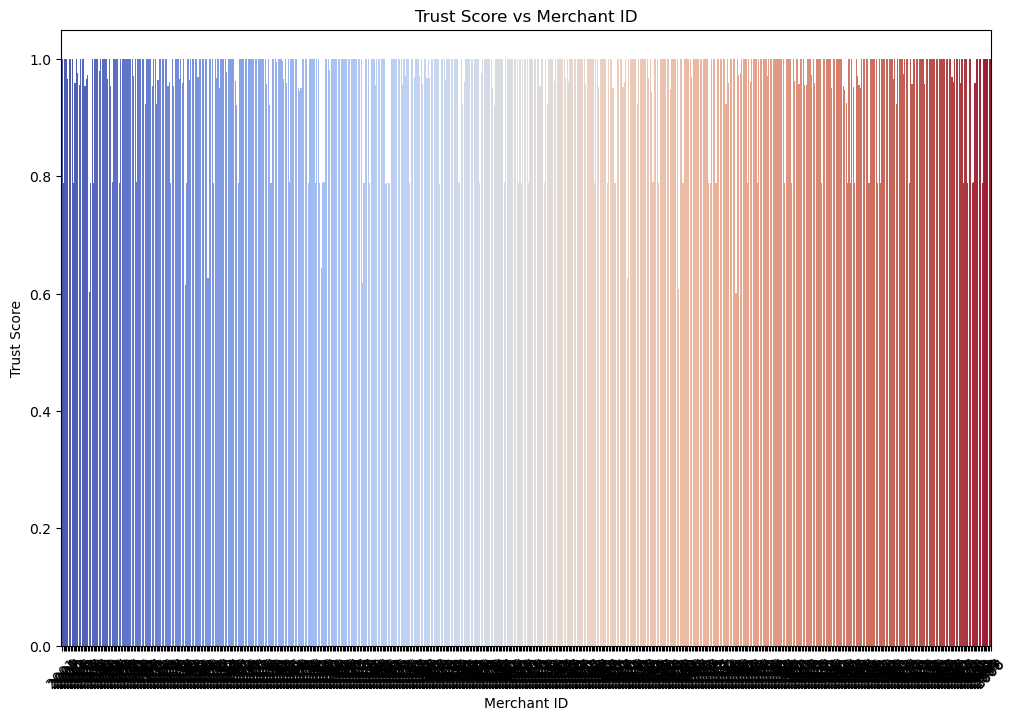

In [57]:
# Group by MerchantID and calculate mean trust score
merchant_trust_scores = transaction_data.groupby('MerchantID')['MerchantTrustScore'].mean().reset_index()

# Sort merchants by trust score
merchant_trust_scores = merchant_trust_scores.sort_values(by='MerchantTrustScore', ascending=False)

# Plot trust score vs merchant ID
plt.figure(figsize=(12, 8))
sns.barplot(x='MerchantID', y='MerchantTrustScore', data=merchant_trust_scores, palette='coolwarm')
plt.title('Trust Score vs Merchant ID')
plt.xlabel('Merchant ID')
plt.ylabel('Trust Score')
plt.xticks(rotation=45)
plt.show()


C:\Users\91981\anaconda3\hack\envs\hackathon\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\91981\anaconda3\hack\envs\hackathon\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\91981\anaconda3\hack\envs\hackathon\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


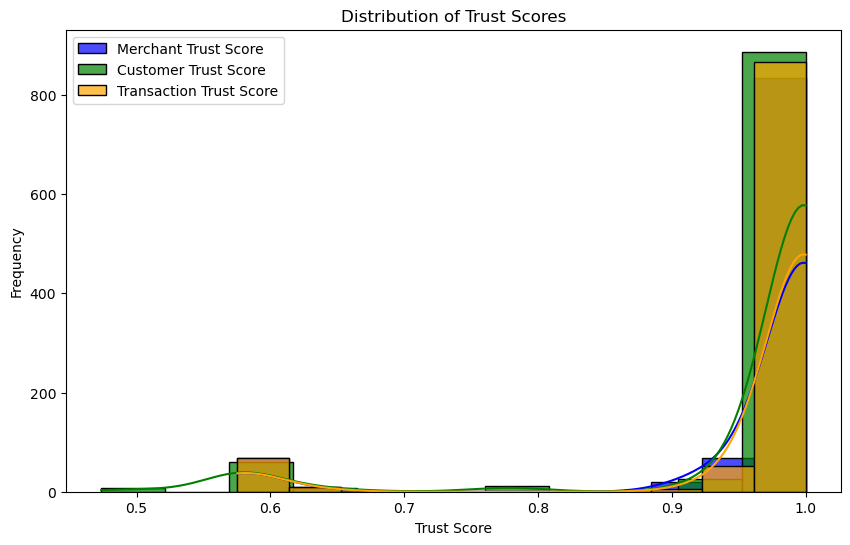

In [58]:
plt.figure(figsize=(10, 6))
sns.histplot(data=transaction_data, x='MerchantTrustScore', kde=True, color='blue', label='Merchant Trust Score', alpha=0.7)
sns.histplot(data=transaction_data, x='CustomerTrustScore', kde=True, color='green', label='Customer Trust Score', alpha=0.7)
sns.histplot(data=transaction_data, x='TransactionTrustScore', kde=True, color='orange', label='Transaction Trust Score', alpha=0.7)
plt.title('Distribution of Trust Scores')
plt.xlabel('Trust Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [59]:
accuracy = np.mean(transaction_data['PredictedFraud'] == transaction_data['FraudIndicator'])
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.954954954954955
